# Two Layer QG Model Example #

Here is a quick overview of how to use the two-layer model. See the
:py:class:`pyqg.QGModel` api documentation for further details.

First import numpy, matplotlib, and pyqg:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pyqg

## Initialize and Run the Model ##

Here we set up a model which will run for 10 years and start averaging
after 5 years. There are lots of parameters that can be specified as
keyword arguments but we are just using the defaults.

In [3]:
year = 24*60*60*360.
m = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year)
m.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 5.13e-04, CFL: 0.096
INFO: Step: 20000, Time: 1.44e+08, KE: 5.25e-04, CFL: 0.101
INFO: Step: 30000, Time: 2.16e+08, KE: 5.13e-04, CFL: 0.104
INFO: Step: 40000, Time: 2.88e+08, KE: 4.79e-04, CFL: 0.088


## Convert Model Outpt to an xarray Dataset ##

Model variables, coordinates, attributes, and metadata can be stored conveniently as an xarray Dataset. (Notice that this feature requires xarray to be installed on your machine. See here for installation instructions: http://xarray.pydata.org/en/stable/getting-started-guide/installing.html#instructions)

In [4]:
m_ds = m.to_dataset().isel(time=-1)
m_ds

<xarray.Dataset>
Dimensions:     (lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
    time        float64 3.11e+08
  * lev         (lev) int64 1 2
  * lev_mid     (lev_mid) float64 1.5
  * x           (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y           (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l           (l) float64 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k           (k) float64 0.0 6.283e-06 1.257e-05 ... 0.0001948 0.0002011
Data variables: (12/25)
    q           (lev, y, x) float64 1.628e-05 7.966e-06 ... 6.348e-07 -1.075e-06
    u           (lev, y, x) float64 -0.03503 -0.09101 ... 0.01665 0.01447
    v           (lev, y, x) float64 0.02985 0.05321 ... 0.006461 -7.769e-05
    ufull       (lev, y, x) float64 -0.01003 -0.06601 ... 0.01665 0.01447
    vfull       (lev, y, x) float64 0.02985 0.05321 ... 0.006461 -7.769e-05
    qh          (lev, l, k) complex128 (0.0022681394575732212+0j) ... (1.1405...
    ...          ...
    Dissspec    (l, k) float64 -0.0 -0.0 -0.0 ... -4.4e-16 -1.041e-19 -1.724e-24
    entspec     (l, k) float64 2.058e-07 4.019e-12 ... 2.607e-34 9.285e-44
    APEflux     (l, k) float64 -0.0 5.32e-08 1.093e-07 ... 2.484e-21 4.265e-26
    KEflux      (l, k) float64 0.0 6.876e-08 6.704e-07 ... 9.836e-20 1.595e-24
    APEgenspec  (l, k) float64 0.0 -6.786e-08 -1.19e-07 ... 9.341e-37 1.684e-45
    APEgen      float64 6.918e-11
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         7200.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         43200
    pyqg:tmax:       311040000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

## Visualize Output ##

Let's assign a new data variable, ``q_upper``, as the **upper layer PV anomaly**. We access the PV values in the Dataset as ``m_ds.q``, which has two levels and a corresponding background PV gradient, ``m_ds.Qy``.

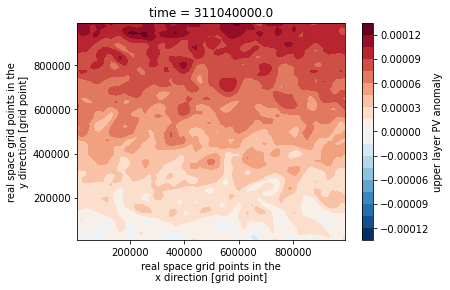

In [5]:
m_ds['q_upper'] = m_ds.q.isel(lev=0) + m_ds.Qy.isel(lev=0)*m_ds.y
m_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}
m_ds.q_upper.plot.contourf(levels=18, cmap='RdBu_r');

## Plot Diagnostics ##

The model automatically accumulates averages of certain diagnostics. We can 
find out what diagnostics are available by calling

In [6]:
m.describe_diagnostics()

NAME               | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total available potential energy generation           
APEgenspec | spectrum of available potential energy generation     
Dissspec   | Spectral contribution of filter dissipation           
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                       
KEspec     | kinetic energy spectrum                               
entspec    | barotropic enstrophy spectrum                         
paramspec  | Spectral contribution of subgrid parameterization (if present)


To look at the wavenumber energy spectrum, we plot the `KEspec` diagnostic.
(Note that summing along the l-axis, as in this example, does not give us
a true *isotropic* wavenumber spectrum.)

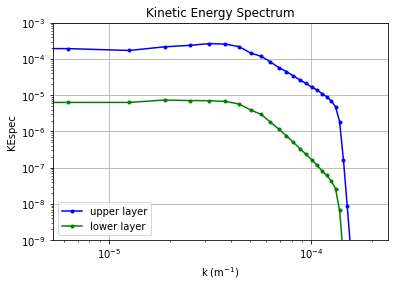

In [7]:
kespec_upper = m_ds.KEspec.isel(lev=0).sum('l')
kespec_lower = m_ds.KEspec.isel(lev=1).sum('l')

kespec_upper.plot.line( 'b.-', x='k', xscale='log', yscale='log', label='upper layer')
kespec_lower.plot.line( 'g.-', x='k', xscale='log', yscale='log', label='lower layer')
plt.legend(loc='lower left')
plt.ylim([1e-9, 1e-3]); 
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum');

We can also plot the spectral fluxes of energy.

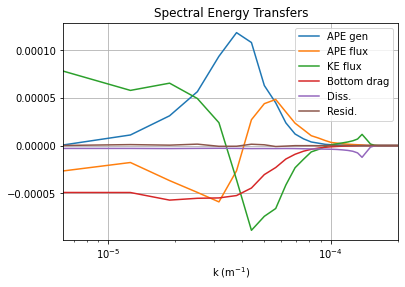

In [9]:
ebud = [ m_ds.APEgenspec.sum('l'),
         m_ds.APEflux.sum('l'),
         m_ds.KEflux.sum('l'),
         -m_ds.attrs['pyqg:rek']*m.del2*m_ds.KEspec.isel(lev=1).sum('l')*m.M**2, 
         m_ds.Dissspec.sum('l'),
       ]
ebud.append(-np.vstack(ebud).sum(axis=0))
ebud_labels = ['APE gen','APE flux','KE flux','Bottom drag','Diss.','Resid.']
[plt.semilogx(m_ds.k, term.squeeze()) for term in ebud]
plt.legend(ebud_labels, loc='upper right')
plt.xlim([m_ds.k[1:].min(), m_ds.k.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Spectral Energy Transfers');
